In [100]:
# Mongo 연결
from pymongo import MongoClient as mc
import random
import pprint as pp

mongo_uri = "mongodb://localhost:27017"
client = mc(mongo_uri)

keti_pr_db = client.keti_pattern_recognition
household_col = keti_pr_db.household_info

total = household_col.count()
db_datas = list(household_col.\
                find().skip(random.randrange(0,total)).limit(1))[0]
# db_datas = household_col.\
#                 find_one({
#                     "uid": "아파트4-103-606"
#                 })

client.close()

# require module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

sns.set(rc={'figure.figsize': (15.7, 13.27)})
plt.rcParams['figure.figsize'] = 15.7,13.27
plt.rcParams['font.family'] = 'AppleGothic'

# custom module
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import custom.supports as sp
import custom.mapgenerator as mg
import custom.dateutils as du

SEASONS = {
    "봄" : [3, 4, 5],
    "여름" : [6, 7, 8],
    "가을" : [9, 10, 11],
    "겨울" : [12, 1, 2]
}

SEASONSARR = ['봄','여름','가을','겨울']

'''
 0 : 봄
 1 : 여름
 2 : 가을
 3 : 겨울
'''

DAYARR = ["월", "화", "수", "목", "금", "토", "일"]

uid, timeslot = db_datas['uid'], db_datas['timeslot']

print("{} pattern recognition".format(uid))

datelist = [
    dt.strptime(ts['time'], "%Y-%m-%d T%H:%M %z").date()
    for ts in timeslot
]
datelist = list(set(datelist))
datelist.sort()

ts_datas = {}
start_idx = 0
end_idx = 96
enl = 1000

for date in datelist:
    ts_datas[date] = [ ts['power'] * enl for ts in timeslot[start_idx:end_idx]]
    start_idx = end_idx
    end_idx = end_idx + 96

ts_datas = pd.DataFrame(ts_datas).T
datas = ts_datas.reset_index().copy()

datas.rename(columns={"index": "date"}, inplace=True)
datas['date'] = pd.to_datetime(datas['date'])
datas['month'] = [dt.month for dt in datas['date']]
datas = [
    datas[(datas['month'].isin(SEASONS[season]))].copy()
    for season in SEASONSARR
]

bak_datas = datas.copy()

season_datas = {
    "봄": datas[0].copy(),
    "여름": datas[1].copy(),
    "가을": datas[2].copy(),
    "겨울": datas[3].copy()
}

season_datas["봄"]

<ipython-input-100-d6edea75253d>:12: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  total = household_col.count()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
아파트3-103-1018 pattern recognition


,date,0,1,2,3,4,5,6,7,8,...,87,88,89,90,91,92,93,94,95,month
0,2018-05-01,52.0,52.0,36.0,45.0,60.0,33.0,47.0,70.0,23.0,...,60.0,46.0,38.0,56.0,34.0,41.0,58.0,33.0,43.0,5
1,2018-05-02,44.0,44.0,44.0,76.0,64.0,38.0,47.0,15.0,30.0,...,42.0,34.0,57.0,41.0,35.0,56.0,38.0,38.0,57.0,5
2,2018-05-03,38.0,38.0,55.0,33.0,42.0,56.0,49.0,78.0,49.0,...,61.0,68.0,53.0,62.0,59.0,56.0,44.0,31.0,60.0,5
3,2018-05-04,40.0,40.0,55.0,48.0,30.0,76.0,76.0,15.0,35.0,...,39.0,38.0,56.0,36.0,40.0,57.0,32.0,45.0,55.0,5
4,2018-05-05,40.0,40.0,51.0,31.0,48.0,52.0,64.0,67.0,29.0,...,26.0,50.0,24.0,41.0,32.0,32.0,41.0,33.0,41.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2019-04-26,57.0,68.0,63.0,62.0,61.0,61.0,35.0,51.0,70.0,...,56.0,45.0,69.0,57.0,44.0,69.0,61.0,45.0,62.0,4
361,2019-04-27,55.0,36.0,86.0,73.0,36.0,59.0,74.0,49.0,60.0,...,57.0,51.0,32.0,58.0,46.0,64.0,62.0,49.0,64.0,4
362,2019-04-28,81.0,81.0,39.0,67.0,59.0,58.0,36.0,70.0,69.0,...,44.0,67.0,58.0,43.0,69.0,60.0,44.0,68.0,59.0,4
363,2019-04-29,44.0,66.0,57.0,38.0,71.0,56.0,29.0,43.0,43.0,...,48.0,66.0,47.0,49.0,78.0,49.0,51.0,68.0,49.0,4


In [101]:
# merge timeslot
timeslot = 3
merge_size = timeslot * 4
merge_datas = season_datas["봄"].copy()
merge_datas = merge_datas[
    merge_datas.columns.difference(['month', 'date'])
]
merge_datas.index = season_datas['봄']['date']

tmp = pd.DataFrame()
start_idx = 0
end_idx = 96
for date in merge_datas.index:
    in_arr = []
    og_arr = merge_datas.loc[date].values
    for merging in range(0, int(end_idx / merge_size)):
        in_arr.append(og_arr[
            (merging) * merge_size
            :
            (merging + 1) * merge_size
        ].sum())
#     logging
#     print("date end : {}, size: {}".format(date, len(in_arr)))
    
    tmp[date] = in_arr
merge_datas = tmp.copy()

merge_datas

,2018-05-01,2018-05-02,2018-05-03,2018-05-04,2018-05-05,2018-05-06,2018-05-07,2018-05-08,2018-05-09,2018-05-10,...,2019-04-21,2019-04-22,2019-04-23,2019-04-24,2019-04-25,2019-04-26,2019-04-27,2019-04-28,2019-04-29,2019-04-30
0,540.0,480.0,530.0,492.0,518.0,415.0,472.0,435.0,380.0,741.0,...,688.0,380.0,659.0,472.0,730.0,661.0,744.0,688.0,578.0,561.0
1,369.0,365.0,295.0,300.0,387.0,385.0,299.0,321.0,290.0,298.0,...,375.0,411.0,539.0,333.0,414.0,253.0,266.0,293.0,356.0,419.0
2,302.0,356.0,375.0,288.0,293.0,223.0,289.0,219.0,289.0,285.0,...,323.0,318.0,313.0,232.0,318.0,216.0,220.0,242.0,303.0,320.0
3,307.0,311.0,390.0,342.0,289.0,271.0,546.0,206.0,414.0,284.0,...,315.0,397.0,503.0,225.0,340.0,218.0,428.0,231.0,305.0,311.0
4,430.0,434.0,739.0,579.0,507.0,214.0,625.0,567.0,478.0,419.0,...,796.0,573.0,695.0,760.0,435.0,987.0,608.0,815.0,537.0,342.0
5,733.0,433.0,606.0,380.0,602.0,726.0,533.0,493.0,472.0,579.0,...,783.0,766.0,792.0,780.0,381.0,785.0,375.0,634.0,885.0,513.0
6,419.0,797.0,501.0,658.0,425.0,599.0,439.0,528.0,384.0,421.0,...,682.0,1070.0,641.0,727.0,682.0,780.0,487.0,605.0,799.0,660.0
7,541.0,531.0,623.0,533.0,428.0,617.0,431.0,416.0,330.0,500.0,...,544.0,671.0,561.0,754.0,669.0,682.0,627.0,683.0,675.0,558.0


In [124]:
from sklearn.cluster import KMeans

means_datas = merge_datas.T.copy()
means_points = means_datas.values

kmeans = KMeans(
    n_clusters=3,
    al
    verbose=1)
kmeans.fit_transform(means_points)

cluster_info = pd.DataFrame()
cluster_info['label'] = kmeans.labels_
cluster_info.index = means_datas.index

cluster_info

Initialization complete
Iteration 0, inertia 9336870.0
Iteration 1, inertia 7630735.446468533
Iteration 2, inertia 7232287.249132231
Iteration 3, inertia 7087827.266535243
Iteration 4, inertia 7027548.150000001
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 13531046.0
Iteration 1, inertia 8066849.86585628
Iteration 2, inertia 7504461.167039929
Iteration 3, inertia 7281083.231184686
Iteration 4, inertia 7069916.849598577
Iteration 5, inertia 7036757.695238096
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 9183248.0
Iteration 1, inertia 7290018.555993674
Iteration 2, inertia 7227301.344717288
Iteration 3, inertia 7171258.740685937
Iteration 4, inertia 7164963.50698825
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10101272.0
Iteration 1, inertia 7350263.911961721
Iteration 2, inertia 7310848.524401915
Iteration 3, inertia 7260725.989089081
Iteration 4, inert

,label
2018-05-01,2
2018-05-02,0
2018-05-03,2
2018-05-04,2
2018-05-05,2
...,...
2019-04-26,2
2019-04-27,2
2019-04-28,2
2019-04-29,0


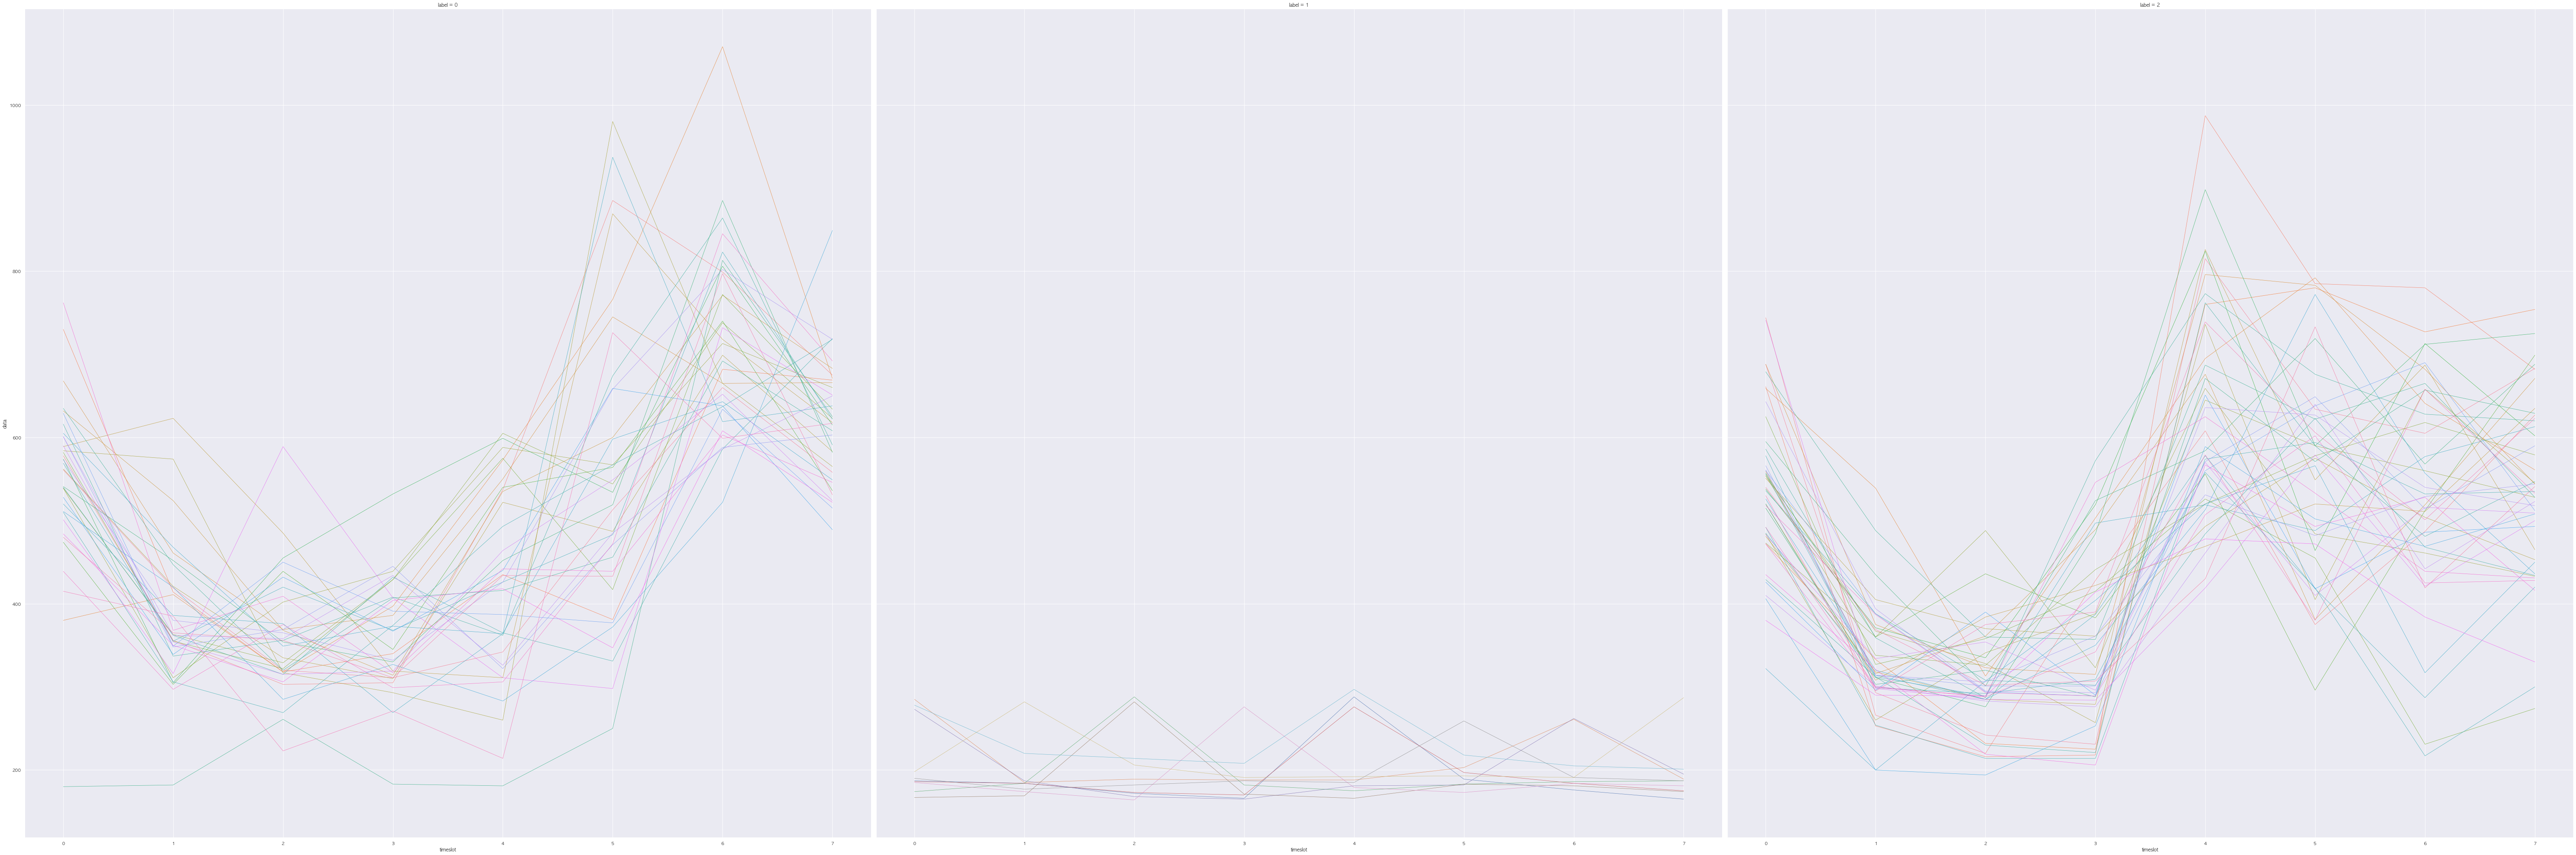

In [125]:
map_datas = pd.DataFrame()

for date in merge_datas:
    tmp = pd.DataFrame()
    tmp['timeslot'] = range(0, 8)
    tmp['data'] = means_datas.loc[date].values
    tmp['date'] = date
    tmp['label'] = cluster_info.loc[date]['label']
    
    map_datas = pd.concat([tmp, map_datas])

_map = sns.FacetGrid(map_datas, col="label", col_wrap=3, height=30)    
_map.map(sns.lineplot, "timeslot", "data", "date", lw=0.7)

In [126]:
cluster_pattern = {}

for num in map_datas['label'].unique():
    date_list = map_datas[
        map_datas['label'] == num
    ]['date'].unique()
    cluster_pattern[num] = merge_datas.T.loc[date_list].mean().values
        
cluster_pattern

{0: array([550.61111111, 382.44444444, 359.22222222, 358.80555556,
        421.33333333, 554.25      , 712.94444444, 619.86111111]),
 2: array([538.91304348, 330.08695652, 305.84782609, 353.10869565,
        622.2826087 , 562.13043478, 533.10869565, 536.06521739]),
 1: array([212.3, 194.6, 203.8, 190.4, 212.7, 198. , 202.1, 194.1])}

In [127]:
kmeans.cluster_centers_

array([[550.61111111, 382.44444444, 359.22222222, 358.80555556,
        421.33333333, 554.25      , 712.94444444, 619.86111111],
       [212.3       , 194.6       , 203.8       , 190.4       ,
        212.7       , 198.        , 202.1       , 194.1       ],
       [538.91304348, 330.08695652, 305.84782609, 353.10869565,
        622.2826087 , 562.13043478, 533.10869565, 536.06521739]])

In [128]:
from scipy.spatial import distance

# Mean_Pattern
mean_pattern = merge_datas.T.copy().mean().values

# TSS
TSS = 0
for date in merge_datas:
    TSS += distance.euclidean(mean_pattern,
                       merge_datas[date].values)

TSS

WSS = 0
for date in merge_datas:
    WSS += distance.euclidean(
        map_datas[
            map_datas['date'] == date
        ]['data'].values        
        ,
        cluster_pattern[
            cluster_info.loc[date]['label']
        ]
    )

ECV = (TSS - WSS) / TSS * 100
print("TSS: {}, WSS: {}, ECV: {}".format(TSS,WSS,ECV))

TSS: 33562.20842129181, WSS: 23364.712230350553, ECV: 30.383865277685313
